## Correlation energy corrections with the adiabatic connection approximation 

This package also provides routines to compute the residual correlation energy for general multideterminant wavefunction approximations using the AC-ERPA approach.


The expression for the correlation energy based on the adiabatic connection is given by:

\begin{align}
    E_{c} &= \braket{\Psi^{\lambda=1}_0 | \hat{H} | \Psi^{\lambda=1}_0} - \braket{\Psi^{\lambda=0}_0 | \hat{H} | \Psi^{\lambda=0}_0}\\
	&=\frac{1}{2} \int_{0}^{1} \sum_{pqrs}  (g^{\lambda=1}_{pqrs} - g^{\lambda=0}_{prqs})
	(\Gamma^{\lambda}_{pqrs} - \Gamma^{\lambda=0}_{pqrs}) d \lambda
\end{align}
where $g^{\lambda=1}_{pqrs}$ and $g^{\lambda=0}_{pqrs}$ are the two-electron integrals from the real and model Hamiltonians, respectively,
and $\Gamma^{\lambda}_{pqrs}$ and $\Gamma^{\lambda=0}_{pqrs}$ are the 2-RDMs at every perturbation strength value $\lambda$ and for the reference state, respectively. The two-electron integrals are defined in **physicist's** notation as $g_{pqrs} = <p q| r s> $.

In this tutorial the perturbation dependent 2-RDMs ($\Gamma^{\lambda}_{pqrs}$) will be computed using the particle-hole ERPA approach. Through this examples we use the $H_4$ chain molecule as simple demonstration system.

Tasks:
 - Compute the correlation energy based on the AC-ERPA for the Hartree-Fock (HF) and DOCI approximations.
 - Plot the adiabatic connection integrand for the DOCI correction.


In [ ]:
#
# If running this notebook in Google colab, uncomment the following lines to install PyEOM and download
# the necessary data files.
#

# ! python -m pip install git+https://github.com/gabrielasd/pyeom.git

# import os
# from urllib.request import urlretrieve

# # download the required data files
# file_path_1 = "h4_chain_1.40_631g_oneint.npy"
# if not os.path.isfile(file_path_1):
#   url = "https://github.com/gabrielasd/eomee/tree/master/eomee/test/data/h4_chain_1.40_631g_oneint.npy?raw=true"
#   urlretrieve(url, file_path_1)
# file_path_2 = "h4_chain_1.40_631g_twoint.npy"
# if not os.path.isfile(file_path_2):
#     url = "https://github.com/gabrielasd/eomee/tree/master/eomee/test/data/h4_chain_1.40_631g_twoint.npy?raw=true"
#     urlretrieve(url, file_path_2)
# file_path_3 = "h4_chain_1.40_631g_doci_rdm1.npy"
# if not os.path.isfile(file_path_1):
#   url = "https://github.com/gabrielasd/eomee/tree/master/eomee/test/data/h4_chain_1.40_631g_doci_rdm1.npy?raw=true"
#   urlretrieve(url, file_path_1)
# file_path_4 = "h4_chain_1.40_631g_doci_rdm2.npy"
# if not os.path.isfile(file_path_2):
#     url = "https://github.com/gabrielasd/eomee/tree/master/eomee/test/data/h4_chain_1.40_631g_doci_rdm2.npy?raw=true"
#     urlretrieve(url, file_path_2)


In [1]:
import numpy as np

from eomee.test import find_datafile
from eomee.tools.tools import hartreefock_rdms, spinize, spinize_rdms
from eomee.tools.tools import make_spinized_fock_hamiltonian, make_doci_ham_spinized
from eomee.spinadapted.excitation import eval_ecorr, ac_integrand_pherpa

In [2]:
# Set up the calculation taking the H4 chain at 1.40 Bohr as an example.
# Load the electron integrals and specify the number of electrons and basis functions
one_int = np.load(find_datafile('h4_chain_1.40_631g_oneint.npy'))
two_int = np.load(find_datafile('h4_chain_1.40_631g_twoint.npy'))
nbasis = one_int.shape[0]
nelecs = (2, 2)  # number of alpha and beta electrons

To run this type of calculation the user needs to specify:
1. the Hamiltonian for the real/fully-interacting system
2. the Hamiltonian corresponding to a given wavefunction approximation 
3. the 1- and 2-RDMs for the approximate wavefunction

### Example 1: Hartree-Fock (HF) model system

In [3]:
# 1. Build the Hamiltonians for the real system (at lambda=1)
h1 = spinize(one_int)
v1 = spinize(two_int)

In [4]:
# 3. Obtain the density matrices for the model system (at lambda=0).
# Here we take non-interacting system as described by Hartree-Fock.
rdm1_hf, rdm2_hf = hartreefock_rdms(nbasis, *nelecs)

In [5]:
# 2. Build the Hamiltonian for the model system.
# For the zeroth-order approximation given by Hartree-Fock, the utility function `make_spinized_fock_hamiltonian`
# can be used to help build the necessary one- and two-electron integrals.
h0, v0 = make_spinized_fock_hamiltonian(one_int, two_int, rdm1_hf)

The cell bellow shows how to compute the correlation energy for the Hartree-Fock (HF) approximation based
on the AC-ERPA method.

In [6]:
ecorr_hf = eval_ecorr(h0, v0, h1, v1, rdm1_hf, rdm2_hf)


print("Ecorr (HF) = ", ecorr_hf)

Ecorr (HF) =  -0.042217146604025424


### Example 2: Double Occupied Configuration Interaction (DOCI) approximation

Repeat steps 2. and 3. from the previous example taking the model system as described by the DOCI wavefunction approximation.

In [7]:
# 2. Load the density matrices for the DOCI reference
dm1 = np.load(find_datafile('h4_chain_1.40_631g_doci_rdm1.npy'))
dm2_aa, dm2_ab, dm2_bb = np.load(find_datafile('h4_chain_1.40_631g_doci_rdm2.npy'))
rdm1_doci = spinize_rdms(dm1)
rdm2_doci = spinize_rdms([dm2_aa, dm2_bb, dm2_ab])


# 3. Build the Hamiltonians for DOCI (at lambda=0)
h0_doci, v0_doci = make_doci_ham_spinized(one_int, two_int)

In [8]:
# Compute the residual correlation energy for DOCI
ecorr_doci = eval_ecorr(h0_doci, v0_doci, h1, v1, rdm1_doci, rdm2_doci)


print("Ecorr = ", ecorr_doci)

Ecorr =  -0.00814677529708373


### Visualize the adiabadic connection integrand for the AC-ERPA correction.

By specifiying the perturbation parameter $\lambda$ between 0 and 1 one can compute the adiabatic connection integrand for the DOCI zeroth-order approximation.
Using the function `ac_integrand_pherpa` of the `particlehole` module. This function requires the following arguments:


In [9]:
# Define the path for the perturbation parameter
lambdas = np.arange(0.0, 1.2, 0.2)

# Get the one- and two-electron perturbation operators matrix elements (denoted as dh and dv)
dh = h1 - h0_doci
dv = v1 - v0_doci

# Compute the integrand for the AC correction
params = (h0_doci, v0_doci, dh, dv, rdm1_doci, rdm2_doci)
Itotal_doci = [ac_integrand_pherpa(ld, *params) for ld in lambdas]

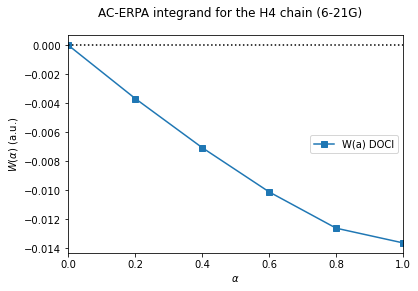

In [10]:
# Plot the AC integrand
import matplotlib.pyplot as plt


plt.plot(lambdas, Itotal_doci, label=f'W(a) DOCI', marker='s')
plt.axhline(y = 0.00, color = 'k', linestyle = ':') 
plt.xlim(0.0, 1.0)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$W(\alpha)$ (a.u.)')
plt.legend(loc='right')
plt.suptitle(f"AC-ERPA integrand for the H4 chain (6-21G)")
plt.show()